# TRGAN

### Kirill Zakharov
### Supervisors: Elizaveta Stavinova, Anton Lysenko

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
import scipy.stats as sts
from tqdm import tqdm

from TRGAN.TRGAN_main import *
from TRGAN.encoders import *
import TRGAN.TRGAN_train_load_modules as trgan_train
from TRGAN.evaluation_metrics import *
from TRGAN.methods_comparison import *
import TRGAN.Privacy_modules as privacy_trgan

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

### Import data

In [2]:
data = pd.read_csv('Data/transactions_RNF.csv')

In [3]:
data.head()

,client,card,date,amt,mcc,group,value
0,390989,3048567,2018-01-01,878.0,5814,food,survival
1,1309946,3226559,2018-01-01,249.0,5411,food,survival
2,1386278,2715990,2018-01-01,50.0,5499,food,survival
3,475694,2884069,2018-01-01,2564.0,5941,fun,self_realization
4,710293,3396065,2018-01-01,464.9,5814,food,survival


In [4]:
data.shape

(19262668, 7)

### Filter data for train

In [5]:
data = data.rename(columns={"client": "customer", "card": 'terminal', 'amt': 'amount', 'date': 'transaction_date'})

data = data.drop(np.where(data['amount'] <= 0)[0])
data = data.iloc[np.where(((data['amount'] >= 0.1) & (data['amount'] <= 4_000)))[0]]

idx_terminal = (data['terminal'].value_counts().loc[(data['terminal'].value_counts() > 100) == True]).index.tolist()
data = data[data['terminal'].isin(idx_terminal)]

idx_mcc = (data['mcc'].value_counts().loc[(data['mcc'].value_counts() > 130) == True]).index.tolist()
data = data[data['mcc'].isin(idx_mcc)]
data = data.loc[data[data['mcc'] != 742].index]

idx_customer = (data['customer'].value_counts().loc[(data['customer'].value_counts() > 300) == True]).index.tolist()
data = data[data['customer'].isin(idx_customer)]

In [6]:
mcc_codes = pd.read_csv('Data/mcc2big.csv', index_col=0)
mcc_transcription = pd.read_table('Data/87_categories.tsv', index_col=0, header=None)

idx_fin_service = mcc_transcription[mcc_transcription[1] == 'Финансовые услуги'].index[0]
mcc_fin_service = mcc_codes[mcc_codes['0'] == idx_fin_service].index.values
data = data[~data['mcc'].isin(mcc_fin_service)]

values = data['value'].value_counts()[:4].index
data = data[data['value'].isin(values)]

In [7]:
data_test = data.iloc[6_300_000:6_500_000]
data = data.iloc[6_100_000:6_300_000]

In [8]:
idx_customer = (data['customer'].value_counts().loc[(data['customer'].value_counts() > 10) == True]).index.tolist()
data = data[data['customer'].isin(idx_customer)]

idx_customer_test = (data_test['customer'].value_counts().loc[(data_test['customer'].value_counts() > 10) == True]).index.tolist()
data_test = data_test[data_test['customer'].isin(idx_customer_test)]

In [9]:
mcc_by_values = []

for val in values.values:
    mcc_by_values.append([val, data[data['value'] == val]['mcc'].unique()])

mcc_by_values = dict(mcc_by_values)

data = data.drop(['group', 'value'], axis=1)

data_test = data_test.drop(['group', 'value'], axis=1)
data_test = data_test.reset_index(drop=True)

In [10]:
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data_test['transaction_date'] = pd.to_datetime(data_test['transaction_date'])

Save preprocessed data

In [11]:
# data.to_csv(f'Data/transactions_{experiment_id}.csv', index=False)
# data_test.to_csv(f'Data/test_data_{experiment_id}.csv', index=False)

# with open(f'mcc_by_values_{experiment_id}.pkl', 'wb') as fp:
#     pickle.dump(mcc_by_values, fp)

Load preprocessed data

In [12]:
# data = pd.read_csv(f'Data/transactions_{experiment_id}.csv')
# data['transaction_date'] = pd.to_datetime(data['transaction_date'])
# data_test = pd.read_csv(f'Data/test_data_{experiment_id}.csv')
# data_test['transaction_date'] = pd.to_datetime(data_test['transaction_date'])


# with open(f'mcc_by_values_{experiment_id}.pkl', 'rb') as fp:
#     mcc_by_values = pickle.load(fp)

In [13]:
data.head()

,customer,terminal,transaction_date,amount,mcc
7556245,1073658,4522419,2020-02-07,404.4,5912
7556246,46525,4550790,2020-02-07,600.0,5641
7556247,3067860,5045574,2020-02-07,560.0,7832
7556248,2896563,4604008,2020-02-07,2055.0,5947
7556249,190858,3043895,2020-02-07,290.0,5812


In [14]:
data.shape

(182786, 5)

In [15]:
data_test.shape

(182869, 5)

In [16]:
# synth_banksformer = pd.read_csv('Data/synth_banksformer_uk.csv')
# synth_banksformer['date'] = pd.to_datetime(synth_banksformer['date'])

# synth_banksformer = synth_banksformer.rename(columns={'tcode': 'mcc', 'date': 'transaction_date', 'account_id': 'customer'})
# synth_banksformer['mcc'] = le.fit_transform(synth_banksformer['mcc'])

# synth_banksformer = synth_banksformer[['mcc', 'transaction_date', 'customer', 'amount']]

# deltas_by_clients_banksformer = synth_banksformer.groupby('customer')['transaction_date'].apply(lambda x: (x - x.shift()).dt.days.values[1:])

### Initialize all constants

In [17]:
'''
FEATURES NAMES
'''
cat_features = ['mcc']
cont_features = ['amount']
date_feature = ['transaction_date']
client_info = ['customer']

# data_cat = data[cat_features] 

'''
DIMENSIONS
'''
dim_X_cat = len(cat_features)
dim_cont_emb = 1
dim_X_cont = dim_cont_emb * len(cont_features)
dim_X_date = 4
dim_Xoh = 40 # dimension of X one hot embeddings
dim_Xcl = 4  # dimension of client's info embeddings
dim_Vc_h = 10 # dimension of conditional vector
dim_bce = 5 # dimension of the behaviour client encoding
dim_Vc = dim_Vc_h + dim_X_date
dim_X_emb = dim_Xoh + dim_X_cont + dim_Xcl
dim_noise = 25
# data_dim = len(data_transformed[0])

'''
LEARNING RATES
'''
lr_E_oh = 8e-4
lr_E_cl = 3e-4
lr_E_Vc = 3e-4
lr_E_cont = 8e-4

'''
SAVE DIRECTORY
'''
DIRECTORY = 'Pretrained_model/'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Create OneHot representation of all categorical features $X_{oh}$ of dimension $d_{X_{oh}}$

In [18]:
experiment_id = 'RNF_3'
load = False

In [19]:
X_oh = onehot_emb_categorical(data, cat_features)

### Create embeddings of the $X_{oh}$

In [20]:
X_oh_emb, encoder_onehot, decoder_onehot = trgan_train.create_cat_emb(X_oh, dim_Xoh, lr_E_oh, epochs=20, batch_size=2**8,\
    load=load, directory=DIRECTORY, names=[f'TRGAN_E_oh_exp_{experiment_id}.pkl', f'TRGAN_D_oh_exp_{experiment_id}.pkl',\
    f'X_oh_emb_exp_{experiment_id}.npy'], device=DEVICE)

  0%|          | 0/20 [00:00<?, ?it/s]

E_oh with (2, 0.1)-Differential Privacy


Loss E_oh: 2.361293525154906e-07 || Privacy Loss E_oh: 0.6888788938522339: 100%|██████████| 20/20 [03:27<00:00, 10.38s/it]   


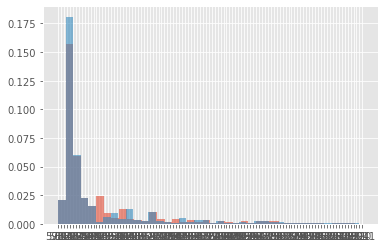

In [21]:
plt.hist(undummify(X_oh), bins=40, alpha=0.6, density=True)
plt.hist(undummify(pd.DataFrame(decoder_onehot(torch.FloatTensor(X_oh_emb).to(DEVICE)).detach().cpu().numpy(), columns=X_oh.columns)), bins=40, alpha=0.6, density=True)

plt.show()

### Create embeddings of the $X_{cont}$

In [22]:
X_cont, scaler_cont = trgan_train.create_cont_emb(dim_X_cont, data, cont_features, lr_E_cont, epochs=20, batch_size=2**8,\
            load=load, directory='Pretrained_model/', names=f'scaler_cont_{experiment_id}.npy', type_scale='CBNormalize', device=DEVICE)

### Create embeddings of the $X_{cl}$

In [23]:
X_cl, encoder_cl_emb, decoder_cl_emb, scaler_cl_emb, label_encoders = trgan_train.create_client_emb(dim_Xcl, data, client_info,\
    dim_Xcl, lr_E_cl, epochs=20, batch_size=2**8, load=load, directory=DIRECTORY, names=[f'TRGAN_E_cl_{experiment_id}.pkl',\
    f'TRGAN_D_cl_{experiment_id}.pkl', f'X_cl_{experiment_id}.npy', f'scaler_{experiment_id}.joblib', f'label_enc_{experiment_id}.joblib'], device=DEVICE)

  0%|          | 0/20 [00:00<?, ?it/s]

E_cl with (0.5, 0.1)-Differential Privacy


Loss E_cl: 8.328690910275327e-07 || Privacy Loss E_cl: -0.00978359766304493: 100%|██████████| 20/20 [03:08<00:00,  9.42s/it]   


### Create embeddings $X_{emb}$

In [24]:
X_emb, scaler_emb = create_embeddings(X_cont, X_oh_emb, X_cl)

### Create conditional vector $v$

In [25]:
cond_vector, synth_time, date_transformations, behaviour_cl_enc, encoder, deltas_by_clients, synth_deltas_by_clients, xiP_array, idx_array =\
    trgan_train.create_conditional_vector(data, X_emb, date_feature, 'synth', dim_Vc_h, dim_bce, \
    name_client_id='customer', name_agg_feature='amount', lr_E_Vc=lr_E_Vc, epochs=15, batch_size=2**8,\
    model_time='poisson', n_splits=4, load=load, directory=DIRECTORY, names=[f'TRGAN_E_Vc_{experiment_id}.pkl',\
    f'Vc_{experiment_id}.npy', f'BCE_{experiment_id}.npy'], opt_time=True, device=DEVICE)

  0%|          | 0/15 [00:00<?, ?it/s]

E_cv with (0.5, 0.1)-Differential Privacy


Loss E_cv: 0.000190178 || Privacy Loss E_cv: -0.017529257: 100%|██████████| 15/15 [02:23<00:00,  9.60s/it]


In [26]:
print(f'Dim X_emb: {X_emb.shape} || Dim V_c: {cond_vector.shape}')

Dim X_emb: (182786, 45) || Dim V_c: (182786, 14)


### Synth time comparison

In [27]:
real_deltas = np.hstack(deltas_by_clients.values)
synth_pois_deltas = np.hstack(synth_deltas_by_clients)
# synth_deltas_banksformer = np.hstack(deltas_by_clients_banksformer)

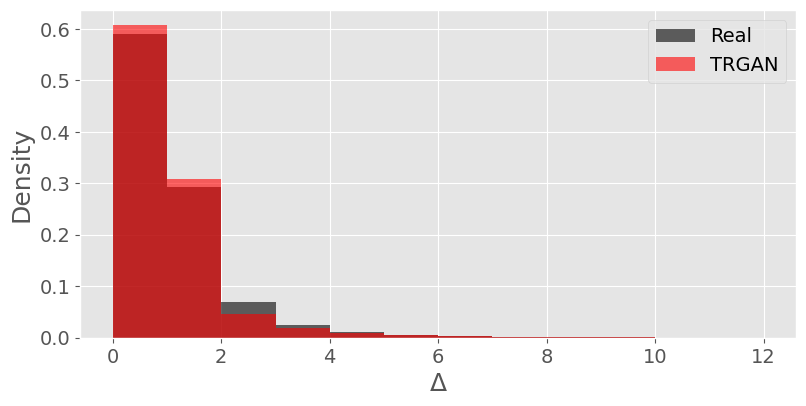

In [28]:
plt.subplots(figsize=(8, 4), dpi=100)

plt.hist(real_deltas, alpha=0.6, bins=np.arange(-1, 12) + 1, label='Real', density=True, color='black')
plt.hist(synth_pois_deltas, alpha=0.6, bins=np.arange(-1, 12) + 1, label='TRGAN', density=True, color='red')

plt.legend(fontsize=14)
plt.xlabel('$\Delta$', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.tick_params(labelsize=14)
plt.locator_params(axis='x', integer=True)
# plt.ylim((0, 0.4))
# plt.set_xlim((-0.2, 12.5))

plt.subplots_adjust(wspace=0.1)
plt.tight_layout(pad=0.5)

# plt.savefig('synth_deltas_rnf.pdf', dpi=300)
plt.show()

In [29]:
evaluate_numerical([pd.Series(real_deltas), pd.Series(synth_pois_deltas)], index=['Real', 'TRGAN'])

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,0.626452,1.048089,19.484691,3.352581,0.000000,0.000000,0.00000
TRGAN,0.566484,0.997907,24.519898,3.804976,0.119797,0.031998,0.05999


### Train TRGAN

In [30]:
load=False

In [31]:
h_dim = 2**6
num_blocks_gen = 1
num_blocks_dis = 1
gauss_filter_dim = 20

if load:
    generator = Generator(dim_noise + dim_Vc, dim_X_emb, h_dim, num_blocks_gen, gauss_filter_dim, DEVICE).to(DEVICE)
    supervisor = Supervisor(dim_X_emb + dim_Vc, dim_X_emb, h_dim, num_blocks_gen, gauss_filter_dim, DEVICE).to(DEVICE)

    generator.load_state_dict(torch.load(f'{DIRECTORY}TRGAN_generator_exp_{experiment_id}.pkl'))
    supervisor.load_state_dict(torch.load(f'{DIRECTORY}TRGAN_supervisor_exp_{experiment_id}.pkl'))

    generator.eval()
    supervisor.eval()

    loss_array = np.load(f'{DIRECTORY}loss_array_exp_{experiment_id}.npy')

else:
    generator, supervisor, loss_array, discriminator, discriminator2, _ = privacy_trgan.train_generator(X_emb, cond_vector, dim_Vc, dim_X_emb, dim_noise, batch_size=2**9,\
                            lr_rates=[3e-4, 3e-4, 3e-4, 3e-4], num_epochs=40, num_blocks_gen=num_blocks_gen, num_blocks_dis=num_blocks_dis, h_dim=h_dim,\
                            lambda1=3, alpha=0.75, window_size=gauss_filter_dim, device=DEVICE)
    
    torch.save(generator.state_dict(), f'{DIRECTORY}TRGAN_generator_exp_{experiment_id}.pkl')
    torch.save(supervisor.state_dict(), f'{DIRECTORY}TRGAN_supervisor_exp_{experiment_id}.pkl')

    np.save(f'{DIRECTORY}loss_array_exp_{experiment_id}.npy', loss_array)

    generator.eval()
    supervisor.eval()

  0%|          | 0/40 [00:00<?, ?it/s]

TRGAN with (0.001, 0.1)-differential privacy


Discriminator Loss: -0.00127 || Discriminator 2 Loss: 0.00038 || Generator Loss: -0.01281 || Supervisor Loss: -0.01051: 100%|██████████| 40/40 [12:46<00:00, 19.16s/it] 


### Loss functions

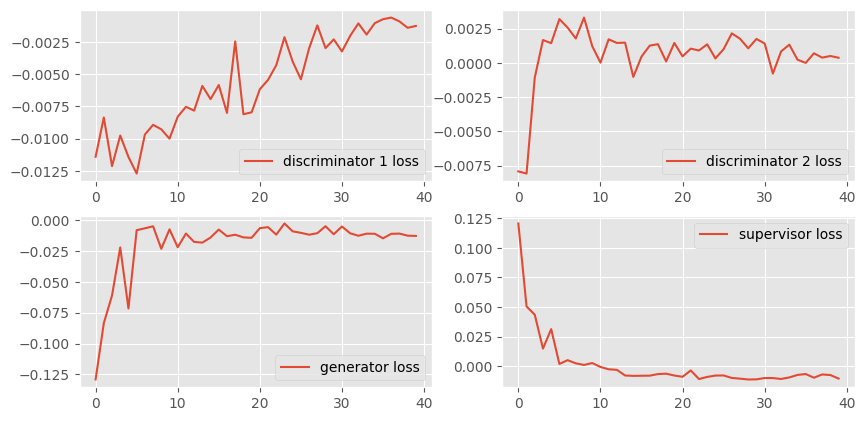

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

axs[0, 0].plot(np.array(loss_array).T[0], label='discriminator 1 loss')
axs[0, 1].plot(np.array(loss_array).T[1], label='discriminator 2 loss')
axs[1, 0].plot(np.array(loss_array).T[2], label='generator loss')
axs[1, 1].plot(np.array(loss_array).T[3], label='supervisor loss')

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
plt.show()

In [33]:
from pytorch_model_summary import summary

print(summary(generator, torch.zeros((512, dim_noise+dim_Vc)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1           [512, 39]           2,560           2,560
       LeakyReLU-2           [512, 64]               0               0
       LayerNorm-3           [512, 64]             128             128
          Linear-4           [512, 64]           4,160           4,160
            ReLU-5           [512, 64]               0               0
         Dropout-6           [512, 64]               0               0
          Linear-7           [512, 64]           4,160           4,160
            ReLU-8           [512, 64]               0               0
         Dropout-9           [512, 64]               0               0
      LayerNorm-10           [512, 64]             128             128
         Linear-11           [512, 64]           2,925           2,925
           Tanh-12           [512, 45]               0               0
Total

In [34]:
# print(summary(discriminator, torch.zeros((512, dim_X_emb+dim_Vc)), show_input=True))

### Generate synthetics

In [35]:
n_samples = len(X_emb)
synth_data, synth_time = sample(n_samples, generator, supervisor, dim_noise, cond_vector, X_emb, encoder, data, behaviour_cl_enc,\
                                date_feature, 'customer', time='synth', model_time='poisson', n_splits=4, opt_time=False,\
                                xi_array=xiP_array, q_array=idx_array, device=DEVICE)

In [36]:
synth_df, synth_df_cat = inverse_transforms(n_samples, synth_data, synth_time, client_info, cont_features, X_oh, scaler_emb, scaler_cl_emb, scaler_cont,\
                    label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont, type_scale_cont='CBNormalize', device=DEVICE)

In [37]:
synth_df

,customer,amount,transaction_date,mcc
0,855127,376.77,2020-02-07,5912
1,2875180,565.61,2020-02-07,5641
2,2423089,549.88,2020-02-07,7832
3,3022112,2124.02,2020-02-07,5947
4,1285582,357.53,2020-02-07,5812
...,...,...,...,...
182781,2557622,276.15,2020-02-29,5411
182782,2272408,2022.56,2020-02-29,5211
182783,1373489,164.95,2020-03-01,5499
182784,2392931,63.27,2020-03-01,7512


In [38]:
data

,customer,terminal,transaction_date,amount,mcc
7556245,1073658,4522419,2020-02-07,404.40,5912
7556246,46525,4550790,2020-02-07,600.00,5641
7556247,3067860,5045574,2020-02-07,560.00,7832
7556248,2896563,4604008,2020-02-07,2055.00,5947
7556249,190858,3043895,2020-02-07,290.00,5812
...,...,...,...,...,...
7795312,1256206,3962783,2020-02-27,287.90,5411
7795313,3264058,4701840,2020-02-27,2103.00,5211
7795314,2557840,3512327,2020-02-27,130.00,5499
7795316,2661188,3552481,2020-02-27,66.29,7512


## Quality Assessment

In [39]:
X_gr = []
X_gr.append(X_emb[:, :21].T[:7])
X_gr.append(X_emb[:, :21].T[7:14])
X_gr.append(X_emb[:, :21].T[14:21])
X_gr = np.array(X_gr)

X_gr_s = []
X_gr_s.append(synth_data[:, :21].T[:7])
X_gr_s.append(synth_data[:, :21].T[7:14])
X_gr_s.append(synth_data[:, :21].T[14:21])
X_gr_s = np.array(X_gr_s)

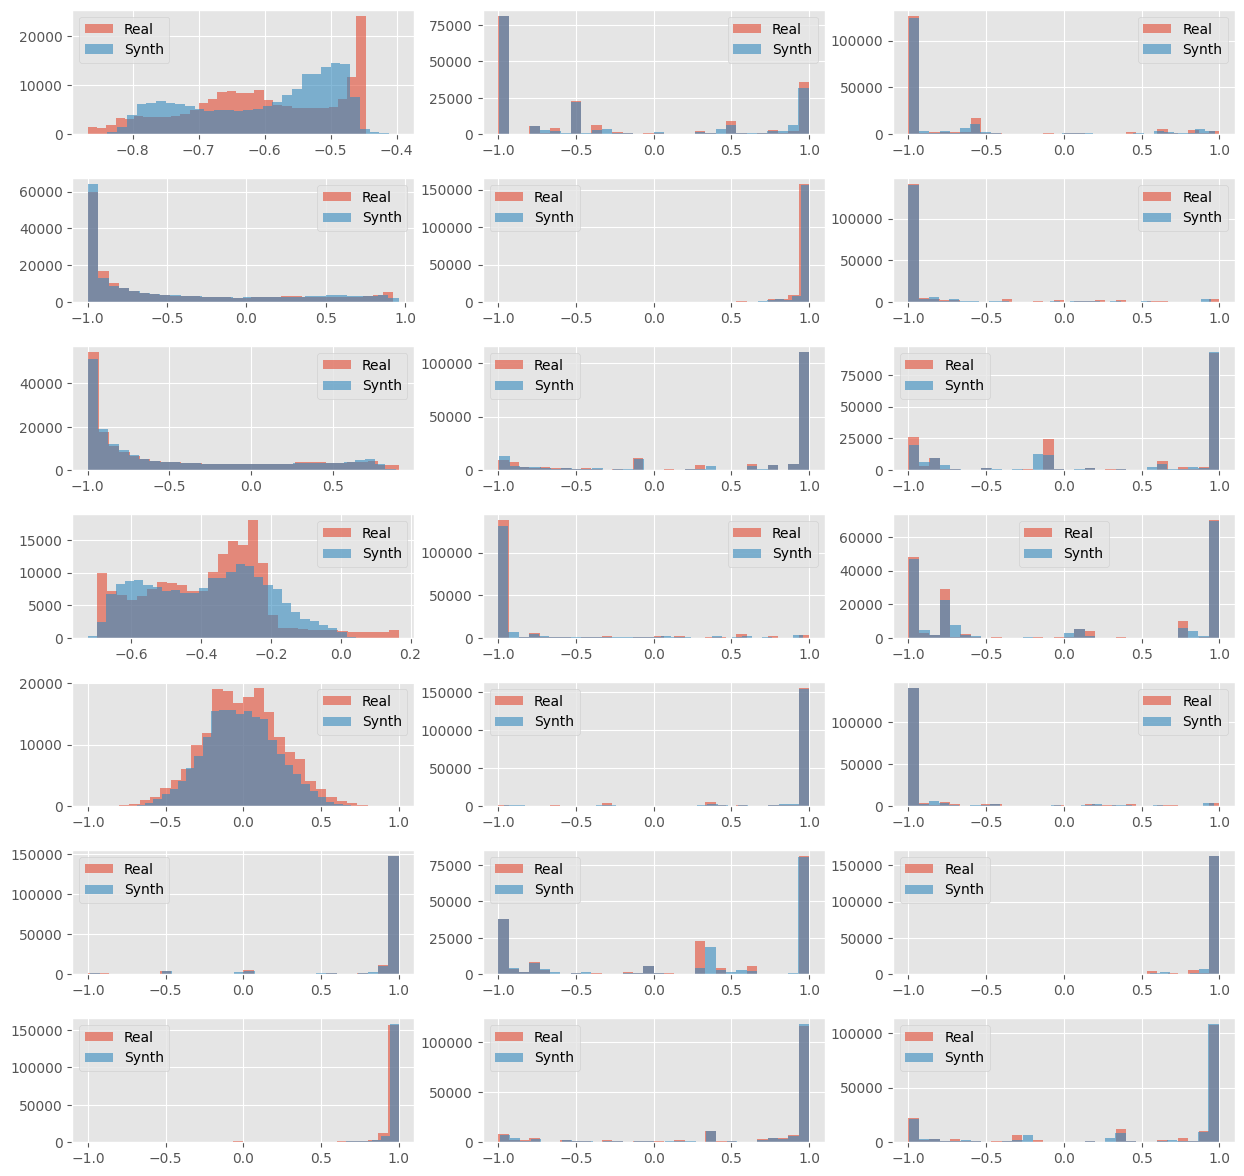

In [40]:
fig, axs = plt.subplots(7, 3, figsize=(15, 15), dpi=100)

for i in range(7):
    for j in range(3):
        axs[i, j].hist(X_gr[j, i], bins=30, label='Real', alpha=0.6)
        axs[i, j].hist(X_gr_s[j, i], bins=30, label='Synth', alpha=0.6)

        axs[i, j].legend()

plt.subplots_adjust(hspace=0.35)
# plt.savefig('results_synth_exp4.png', dpi=300)
plt.show()

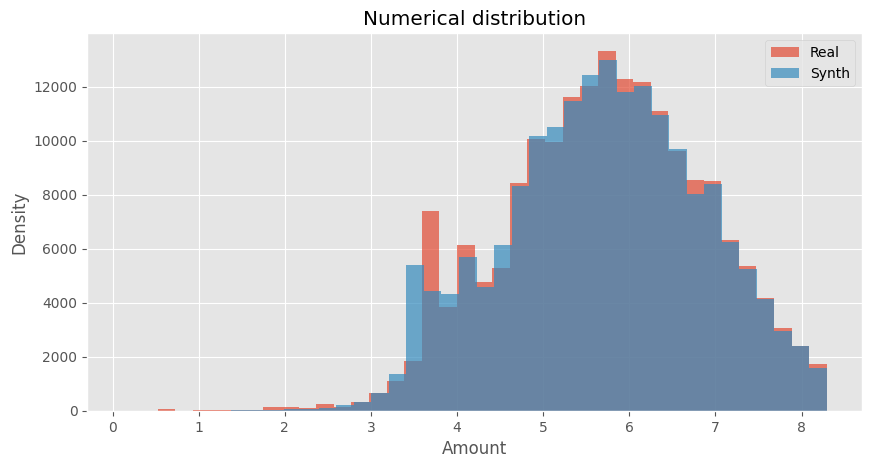

In [41]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.7)
plt.hist(np.log1p(abs(synth_df['amount'])), bins=40, label='Synth', alpha=0.7)

plt.legend()
plt.title('Numerical distribution')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.show()

### Compare mcc

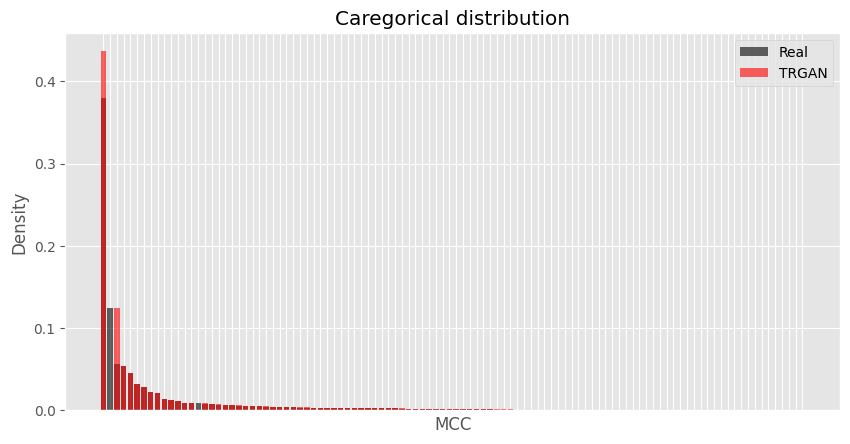

In [42]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.bar(np.sort(data['mcc'].value_counts().index.values).astype(str), data['mcc'].value_counts().values/(np.sum(data['mcc'].value_counts().values)),\
                                                    color='black', alpha=0.6, label='Real')
plt.bar(np.sort(synth_df['mcc'].value_counts().index.values).astype(str), synth_df['mcc'].value_counts().values/(np.sum(synth_df['mcc'].value_counts().values)),\
                                                    color='red', alpha=0.6, label='TRGAN')

# plt.xticks(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.legend()
plt.title('Caregorical distribution')
plt.ylabel('Density')
plt.xlabel('MCC')
plt.show()

In [43]:
metadata = SingleTableMetadata()
metadata.add_column(
    column_name='amount',
    sdtype='numerical',
    computer_representation='Float')

metadata.add_column(
    column_name='mcc',
    sdtype='categorical')


metadata.add_column(
    column_name='customer',
    sdtype='categorical')


metadata.add_column(
    column_name='transaction_date',
    sdtype='datetime',
    datetime_format='%Y %m %d')

In [44]:
evaluate_categorical(data_array=[data['mcc'], synth_df['mcc']], index=['Real', 'TRGAN'], data_cont_array=[data[['mcc', 'transaction_date']], synth_df[['mcc', 'transaction_date']]])

,Total Variation,Contingency Similarity,Values count,D_JS
Real,1.000000,1.000000,104.0,0.00000
TRGAN,0.934995,0.855574,102.0,0.02612


### Compare clients' features

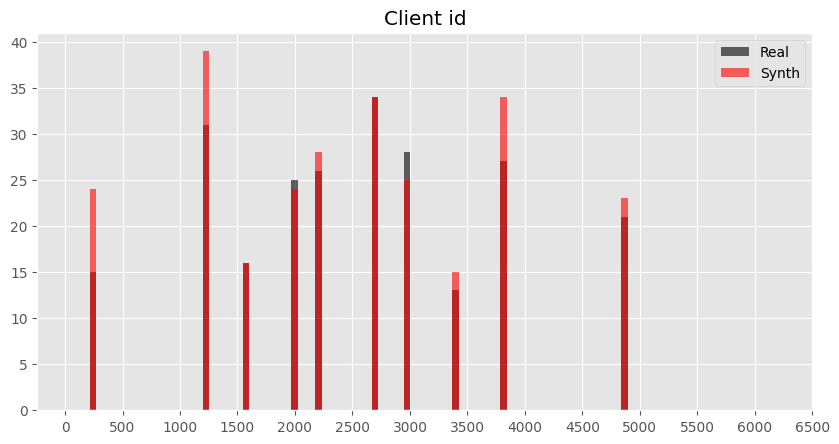

In [47]:
fig, axs = plt.subplots(figsize=(10, 5), dpi=100)

plt.hist(data['customer'], alpha=0.6, label='Real', bins=np.arange(0, 5000, 70), color='black', rwidth=0.8)
plt.hist(synth_df['customer'], alpha=0.6, label='Synth', bins=np.arange(0, 5000, 70), color='red', rwidth=0.8)

plt.legend()
plt.xticks(np.arange(0, len(data['customer'].value_counts()), 500), np.arange(0, len(data['customer'].value_counts()), 500))
plt.title('Client id')

plt.show()

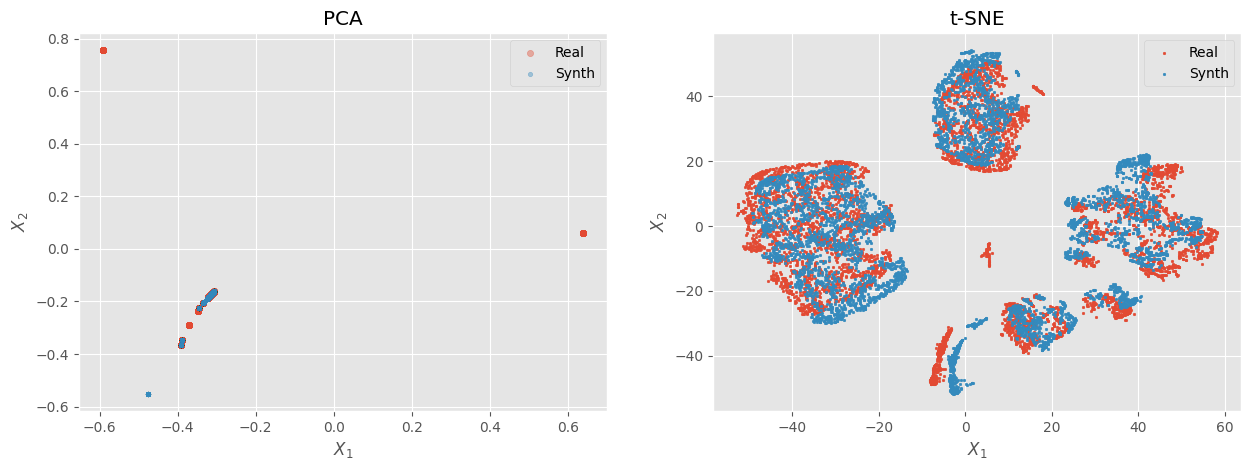

In [51]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca1 = PCA(n_components=2)
# pca2 = PCA(n_components=2)

data_transformed_pca = pca1.fit_transform(X_oh)
synth_pca = pca1.transform(synth_df_cat)
# data_transformed_pca = pca1.fit_transform(X_emb)
# synth_pca = pca2.fit_transform(synth_data)

tsne1 = TSNE(n_components=2, perplexity = 80)
tsne2 = TSNE(n_components=2, perplexity = 80)

idx_random = np.random.randint(0, len(X_emb), 5000)

data_transformed_tsne = tsne1.fit_transform(X_emb[idx_random])
synth_tsne = tsne2.fit_transform(synth_data[idx_random])


figure, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=100)

axs[0].scatter(data_transformed_pca.T[0], data_transformed_pca.T[1], label='Real', alpha=0.4, s=20)
axs[0].scatter(synth_pca.T[0], synth_pca.T[1], label='Synth', alpha=0.4, s=10)

axs[0].legend()
axs[0].set_xlabel('$X_1$')
axs[0].set_ylabel('$X_2$')
axs[0].set_title('PCA')


axs[1].scatter(data_transformed_tsne.T[0], data_transformed_tsne.T[1], label='Real', s=3, alpha=1)
axs[1].scatter(synth_tsne.T[0], synth_tsne.T[1], label='Synth', s=3, alpha=1)

axs[1].legend()
axs[1].set_xlabel('$X_1$')
axs[1].set_ylabel('$X_2$')
axs[1].set_title('t-SNE')

plt.show()

# Scenario modelling

## Scenario modelling by one mcc

In [57]:
mcc = 'mcc_5949'
mcc_tick = '5949'
L = len(X_oh[mcc])
n = X_oh[mcc].value_counts().values[np.where(X_oh[mcc].value_counts().index == 1)[0][0]]

p0 = n/L
p_add = 0.7

m = round((p0+p_add)*L)
rate = m - n

In [58]:
X_oh_sc = change_scenario(X_oh, mcc, data, rate)

In [59]:
n_samples = len(X_emb)
synth_data_sc1, synth_time_sc1 = sample_scenario(n_samples, generator, supervisor, dim_noise, cond_vector,\
        X_oh_sc, scaler_emb, X_cl, X_cont, encoder_onehot, encoder, data, behaviour_cl_enc,\
        date_feature, 'customer', time='synth', model_time='poisson', n_splits=4, opt_time=False,\
        xi_array=xiP_array, q_array=idx_array, device=DEVICE)

synth_df_sc1, synth_df_cat_sc1 = inverse_transforms(n_samples, synth_data_sc1, synth_time_sc1, client_info, cont_features,\
        X_oh, scaler_emb, scaler_cl_emb, scaler_cont, label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont,\
        type_scale_cont='Autoencoder', device=DEVICE)

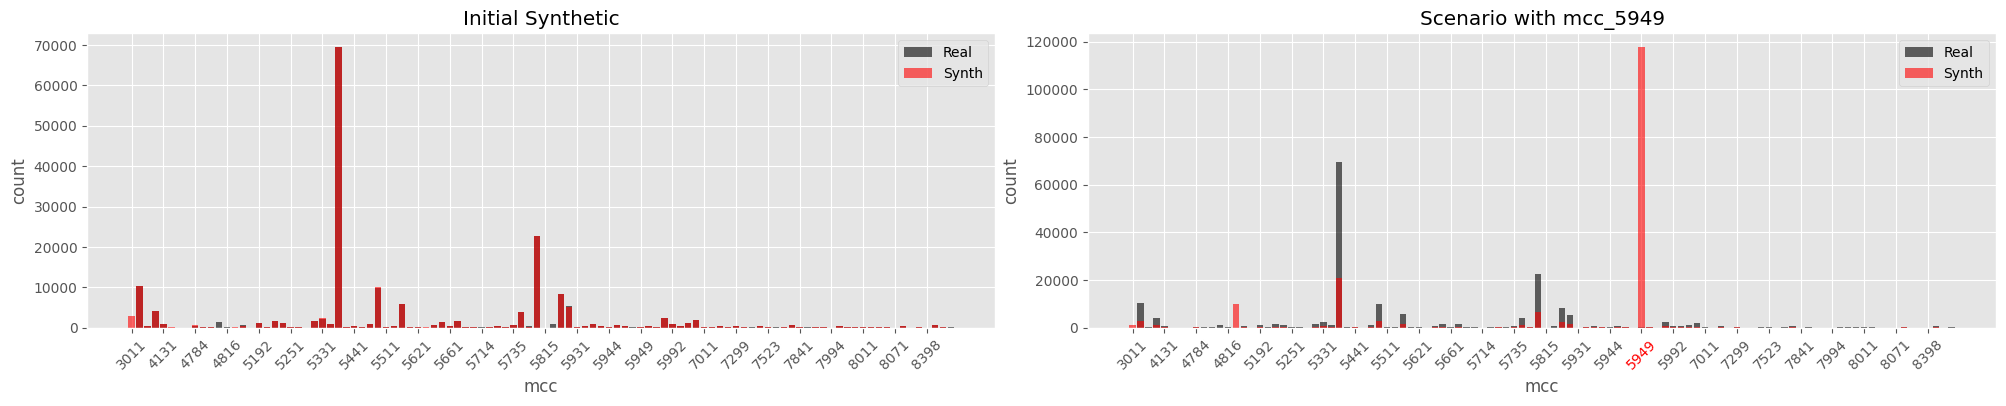

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4), dpi=100)

axs[0].bar(np.sort(data['mcc'].value_counts().index.values).astype(str), data['mcc'].value_counts().sort_index().values, color='black', alpha=0.6, label='Real')
axs[0].bar(np.sort(synth_df['mcc'].value_counts().index.values).astype(str), synth_df['mcc'].value_counts().sort_index().values, color='red', alpha=0.6, label='Synth')


axs[0].legend()
axs[0].set_xlabel('mcc')
axs[0].set_ylabel('count')
axs[0].set_title('Initial Synthetic')
axs[0].set_xticks(np.sort(data['mcc'].unique()).astype(str)[::4])
axs[0].set_xticklabels(np.sort(data['mcc'].unique()).astype(str)[::4], rotation=45)

axs[1].bar(np.sort(data['mcc'].value_counts().index.values).astype(str), data['mcc'].value_counts().sort_index().values, color='black', alpha=0.6, label='Real')
axs[1].bar(np.sort(synth_df_sc1['mcc'].value_counts().index.values).astype(str), synth_df_sc1['mcc'].value_counts().sort_index().values, color='red', alpha=0.6, label='Synth')

axs[1].set_xlabel('mcc')
axs[1].set_ylabel('count')
axs[1].legend()
axs[1].set_title(f'Scenario with {mcc}')
axs[1].set_xticks(np.sort(data['mcc'].unique()).astype(str)[::4])
axs[1].set_xticklabels(np.sort(data['mcc'].unique()).astype(str)[::4], rotation=45)

for i in range(len(axs[1].get_xticklabels())):
    if axs[1].get_xticklabels()[i].get_text() == mcc_tick:
        axs[1].get_xticklabels()[i].set_color('red')

plt.tight_layout(pad=0.5)
# plt.savefig('scenario_by_mcc.pdf', dpi=300)
plt.show()

In [50]:
evaluate_categorical(data_array=[data['mcc'], synth_df['mcc'], synth_df_sc1['mcc']], index=['Real', 'TRGAN', 'TRGAN SC'],\
                    data_cont_array=[data[['mcc', 'customer']], synth_df[['mcc', 'customer']], synth_df_sc1[['mcc', 'customer']]])

,Total Variation,Contingency Similarity,Values count,D_JS
Real,1.000000,1.000000,104.0,0.000000
TRGAN,0.979490,0.457174,101.0,0.024469
TRGAN SC,0.296899,0.173257,101.0,0.041187


In [51]:
evaluate_numerical([data['amount'], synth_df['amount'][:n_samples], synth_df_sc1['amount'][:n_samples]],\
                 ['Real', 'TRGAN', 'TRGAN SC'])

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,549.495169,651.923984,6.216343,2.336945,0.000000,0.000000,0.000000
TRGAN,541.917085,584.253555,2.967028,1.803014,0.031948,0.039418,33.444383
TRGAN SC,548.272773,572.114640,3.218736,1.852243,0.039616,0.069042,39.328103


## Scenario modelling by values

In [52]:
value = 'survival'

L = len(X_oh)

num_ones_array = list(map(lambda x: X_oh['mcc_' + str(x)].value_counts().values[np.where(X_oh['mcc_' + str(x)].value_counts().index == 1)[0][0]], mcc_by_values[value]))
n = sum(num_ones_array)

p0 = n/L
p_add = 0.5
p_add_by_mcc = round(p_add / len(mcc_by_values[value]), 3)

m = round((p0+p_add_by_mcc)*L)
rate = m - n

In [53]:
X_oh_sc = change_scenario_rnf(X_oh, value, mcc_by_values, data, rate)

In [54]:
n_samples = len(X_emb)
synth_data_sc1, synth_time_sc1 = sample_scenario(n_samples, generator, supervisor, dim_noise, cond_vector,\
        X_oh_sc, scaler_emb, X_cl, X_cont, encoder_onehot, encoder, data, behaviour_cl_enc, date_feature,\
        'customer', time='synth', model_time='poisson', n_splits=4, opt_time=False,\
        xi_array=xiP_array, q_array=idx_array, device=DEVICE)

synth_df_sc1, synth_df_cat_sc1 = inverse_transforms(n_samples, synth_data_sc1, synth_time_sc1, client_info, cont_features,\
        X_oh, scaler_emb, scaler_cl_emb, scaler_cont, label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont,\
        type_scale_cont='Autoencoder', device=DEVICE)

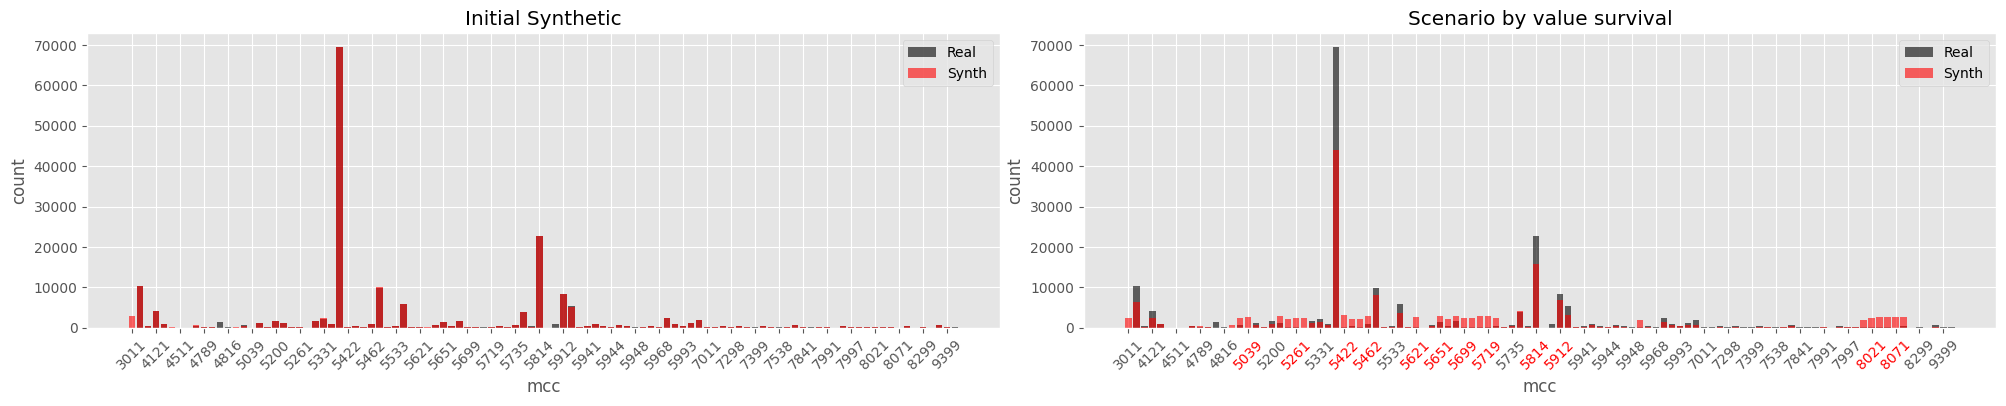

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4), dpi=100)

axs[0].bar(data['mcc'].value_counts().sort_index().index.values.astype(str), data['mcc'].value_counts().sort_index().values, color='black', alpha=0.6, label='Real')
axs[0].bar(synth_df['mcc'].value_counts().sort_index().index.values.astype(str), synth_df['mcc'].value_counts().sort_index().values, color='red', alpha=0.6, label='Synth')


axs[0].legend()
axs[0].set_xlabel('mcc')
axs[0].set_ylabel('count')
axs[0].set_title('Initial Synthetic')
axs[0].set_xticks(np.sort(data['mcc'].unique()).astype(str)[::3])
axs[0].set_xticklabels(np.sort(data['mcc'].unique()).astype(str)[::3], rotation=45)

axs[1].bar(data['mcc'].value_counts().sort_index().index.values.astype(str), data['mcc'].value_counts().sort_index().values, color='black', alpha=0.6, label='Real')
axs[1].bar(synth_df_sc1['mcc'].value_counts().sort_index().index.values.astype(str), synth_df_sc1['mcc'].value_counts().sort_index().values, color='red', alpha=0.6, label='Synth')

axs[1].set_xlabel('mcc')
axs[1].set_ylabel('count')
axs[1].legend()
axs[1].set_title(f'Scenario by value {value}')
axs[1].set_xticks(data['mcc'].value_counts().sort_index().index.values.astype(str)[::3])
axs[1].set_xticklabels(data['mcc'].value_counts().sort_index().index.values.astype(str)[::3], rotation=45)

for i in range(len(axs[1].get_xticklabels())):
    for j in mcc_by_values[value]:
        if axs[1].get_xticklabels()[i].get_text() == str(j):
            axs[1].get_xticklabels()[i].set_color('red')

plt.tight_layout(pad=0.5)
# plt.savefig('scenario_by_value.pdf', dpi=300)
plt.show()

In [54]:
evaluate_categorical(data_array=[data['mcc'], synth_df['mcc'], synth_df_sc1['mcc']], index=['Real', 'TRGAN', 'TRGAN SC'],\
                    data_cont_array=[data[['mcc', 'customer']], synth_df[['mcc', 'customer']], synth_df_sc1[['mcc', 'customer']]])

,Total Variation,Contingency Similarity,Values count,D_JS
Real,1.000000,1.000000,104.0,0.000000
TRGAN,0.971130,0.454291,104.0,0.033372
TRGAN SC,0.695874,0.351148,104.0,0.067835


In [55]:
evaluate_numerical([data['amount'], synth_df['amount'][:n_samples], synth_df_sc1['amount'][:n_samples]],\
                 ['Real', 'Synth TRGAN', 'Synth SC'])

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,549.495169,651.923984,6.216343,2.336945,0.000000,0.000000,0.000000
Synth TRGAN,521.185627,562.035133,2.535722,1.707833,0.035753,0.025740,41.216776
Synth SC,515.457309,566.681073,2.840377,1.775538,0.030602,0.029488,38.310085


## Time continuity

In [56]:
cv_for_test = cond_vector.copy()

In [57]:
min_length = np.minimum(len(data_test), len(cv_for_test))

In [58]:
cv_for_test_final = np.concatenate([cv_for_test[:, :dim_Vc_h][:min_length], preprocessing_date(data_test[:min_length], 'transaction_date')], axis=1)

In [59]:
synth_data_test, synth_time_test = sample(n_samples, generator, supervisor, dim_noise, cond_vector, X_emb, encoder, data, behaviour_cl_enc,\
        date_feature, 'customer', time='synth', model_time='poisson', n_splits=4, opt_time=False,\
        xi_array=xiP_array, q_array=idx_array, device=DEVICE)

synth_df_test, synth_df_cat_test = inverse_transforms(n_samples, synth_data_test, synth_time_test, client_info, cont_features,\
        X_oh, scaler_emb, scaler_cl_emb, scaler_cont, label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont,\
        type_scale_cont='Autoencoder', device=DEVICE)

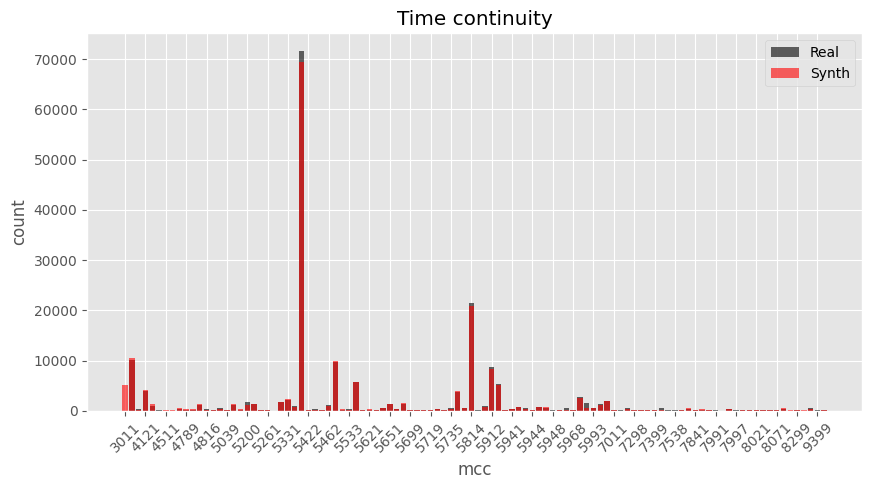

In [60]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.bar(data_test['mcc'].value_counts().sort_index().index.values.astype(str), data_test['mcc'].value_counts().sort_index().values, color='black', alpha=0.6, label='Real')
plt.bar(synth_df_test['mcc'].value_counts().sort_index().index.values.astype(str), synth_df_test['mcc'].value_counts().sort_index().values, color='red', alpha=0.6, label='Synth')

plt.xlabel('mcc')
plt.ylabel('count')
plt.title('Time continuity')
plt.legend()
plt.xticks(data_test['mcc'].value_counts().sort_index().index.values.astype(str)[::3], rotation=45)

# plt.savefig('')
plt.show()

In [61]:
evaluate_categorical(data_array=[data['mcc'], synth_df_test['mcc']], index=['Real', 'TRGAN'],\
                    data_cont_array=[data[['mcc', 'customer']], synth_df_test[['mcc', 'customer']]])

,Total Variation,Contingency Similarity,Values count,D_JS
Real,1.000000,1.000000,104.0,0.000000
TRGAN,0.956605,0.449433,104.0,0.039809


In [62]:
evaluate_numerical([data['amount'], synth_df_test['amount'][:n_samples]],\
                 ['Real', 'Synth TRGAN'])

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,549.495169,651.923984,6.216343,2.336945,0.000000,0.000000,0.000000
Synth TRGAN,533.491143,572.398846,2.100648,1.622040,0.040772,0.026293,47.274935


# Comparison with other models

Prepare metadata for methods

In [36]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.add_column(
    column_name='amount',
    sdtype='numerical',
    computer_representation='Float')

metadata.add_column(
    column_name='mcc',
    sdtype='categorical')

metadata.add_column(
    column_name='transaction_date',
    sdtype='datetime',
    datetime_format='%Y %m %d')

Choose categorical columns for metrics calculation

In [37]:
cat_columns = ['mcc']

### Compare categorical columns

In [38]:
def copulagan(data: pd.DataFrame, metadata, cat_columns=['mcc'], epochs=10, n_samples=10_000, load=False):
    
    if load:
        synthesizer = CopulaGANSynthesizer(metadata, epochs=epochs)
        synthesizer = synthesizer.load(f'{DIRECTORY}CopulaGAN_rnf.pkl')
    else:
        synthesizer = CopulaGANSynthesizer(metadata, epochs=epochs)
        synthesizer.fit(data)
        synthesizer.save(f'{DIRECTORY}CopulaGAN_rnf.pkl')

    synth_copulagan = synthesizer.sample(num_rows=n_samples)

    synth_df_cat_copulagan = pd.get_dummies(synth_copulagan[cat_columns], columns=cat_columns)

    return synth_copulagan, synth_df_cat_copulagan

def ctgan(data: pd.DataFrame, metadata, cat_columns=['mcc'], epochs=10, n_samples=10_000, load=False):

    if load:
        synthesizer = CTGANSynthesizer(metadata, epochs=epochs)
        synthesizer = synthesizer.load(f'{DIRECTORY}CTGAN_rnf.pkl')
    else:
        synthesizer = CTGANSynthesizer(metadata, epochs=epochs)
        synthesizer.fit(data)
        synthesizer.save(f'{DIRECTORY}CTGAN_rnf.pkl')
 
    synth_ctgan = synthesizer.sample(num_rows=n_samples)

    synth_df_cat_ctgan = pd.get_dummies(synth_ctgan[cat_columns], columns=cat_columns)

    return synth_ctgan, synth_df_cat_ctgan

def compare_categorical_w_banksformer(data, synth_df, synth_df_cat, X_oh, metadata, cat_columns, synth_banks,\
                                    epochs=2, n_samples=10_000, comp_col='mcc', contig_cols=['mcc', 'customer'], load=False):
    synth_copulagan, synth_copulagan_cat = copulagan(data, metadata, cat_columns, epochs, n_samples, load)
    synth_ctgan, synth_ctgan_cat = ctgan(data, metadata, cat_columns, epochs, n_samples, load)
    # synth_tvae, synth_tvae_cat = tvae(data, metadata, cat_columns, epochs, n_samples, load)
    synth_banksformer = synth_banks

    fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)

    axs[0, 0].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[0, 0].bar(np.sort(synth_df['mcc'].value_counts().index.values).astype(str),\
            synth_df['mcc'].value_counts().values/np.sum(synth_df['mcc'].value_counts().values), color='red', alpha=0.6, label='TRGAN')
    
    # axs[0, 0].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[0, 0].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[0, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False, labelsize=13)
    axs[0, 0].tick_params(axis='y', labelsize=20)
    axs[0, 0].legend(fontsize=18)
    axs[0, 0].set_xlabel('Category', fontsize=22)
    axs[0, 0].set_ylabel('Density', fontsize=22)
#     axs[0, 0].set_title('TRGAN')


    axs[0, 1].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[0, 1].bar(np.sort(synth_ctgan['mcc'].value_counts().index.values).astype(str),\
            synth_ctgan['mcc'].value_counts().values/np.sum(synth_ctgan['mcc'].value_counts().values), color='lightblue', alpha=0.6, label='CTGAN')

    # axs[0, 1].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[0, 1].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[0, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False, labelsize=13)
    axs[0, 1].tick_params(axis='y', labelsize=20)
    axs[0, 1].legend(fontsize=18)
    axs[0, 1].set_xlabel('Category', fontsize=22)
    # axs[0, 1].set_ylabel('Density', fontsize=16)
#     axs[0, 1].set_title('CTGAN')


    axs[1, 0].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[1, 0].bar(np.sort(synth_copulagan['mcc'].value_counts().index.values).astype(str),\
            synth_copulagan['mcc'].value_counts().values/np.sum(synth_copulagan['mcc'].value_counts().values), color='orange', alpha=0.6, label='CopulaGAN')

    # axs[1, 0].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[1, 0].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[1, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False, labelsize=13)
    axs[1, 0].tick_params(axis='y', labelsize=20)
    axs[1, 0].legend(fontsize=18)
    axs[1, 0].set_xlabel('Category', fontsize=22)
    axs[1, 0].set_ylabel('Density', fontsize=22)
#     axs[1, 0].set_title('CopulaGAN')

    
    # axs[1, 1].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
    #         data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    # axs[1, 1].bar(np.sort(synth_banksformer['mcc'].value_counts().index.values).astype(str),\
    #         synth_banksformer['mcc'].value_counts().values/np.sum(synth_banksformer['mcc'].value_counts().values), color='green', alpha=0.6, label='Banksformer')
    
#     # axs[1, 1].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
#     # axs[1, 1].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
#     axs[1, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False, labelsize=13)
#     axs[1, 1].tick_params(axis='y', labelsize=20)
#     axs[1, 1].legend(fontsize=18)
#     axs[1, 1].set_xlabel('Category', fontsize=22)
#     # axs[1, 1].set_ylabel('Density', fontsize=16)
# #     axs[1, 1].set_title('Banksformer')

#     plt.subplots_adjust(hspace=0.15, wspace=0.12)
#     plt.tight_layout(pad=0.5)
#     plt.savefig('synth_mcc_uk.pdf', dpi=300)
#     plt.show()

    # display(evaluate_new_rows([data, synth_df, synth_ctgan, synth_copulagan, synth_banksformer],\
                # index=['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'], metadata=metadata))

    eval_cat = evaluate_categorical([data[comp_col], synth_df[comp_col], synth_ctgan[comp_col], synth_copulagan[comp_col]],\
                                     index=['Real', 'TRGAN', 'CTGAN', 'CopulaGAN'],\
    data_cont_array=[data[contig_cols], synth_df[contig_cols], synth_ctgan[contig_cols], synth_copulagan[contig_cols]])

    return eval_cat

,Total Variation,Contingency Similarity,Values count,D_JS
Real,1.000000,1.000000,104.0,0.000000
TRGAN,0.974134,0.888017,103.0,0.028583
CTGAN,0.978193,0.732359,104.0,0.060554
CopulaGAN,0.978855,0.815227,104.0,0.060441


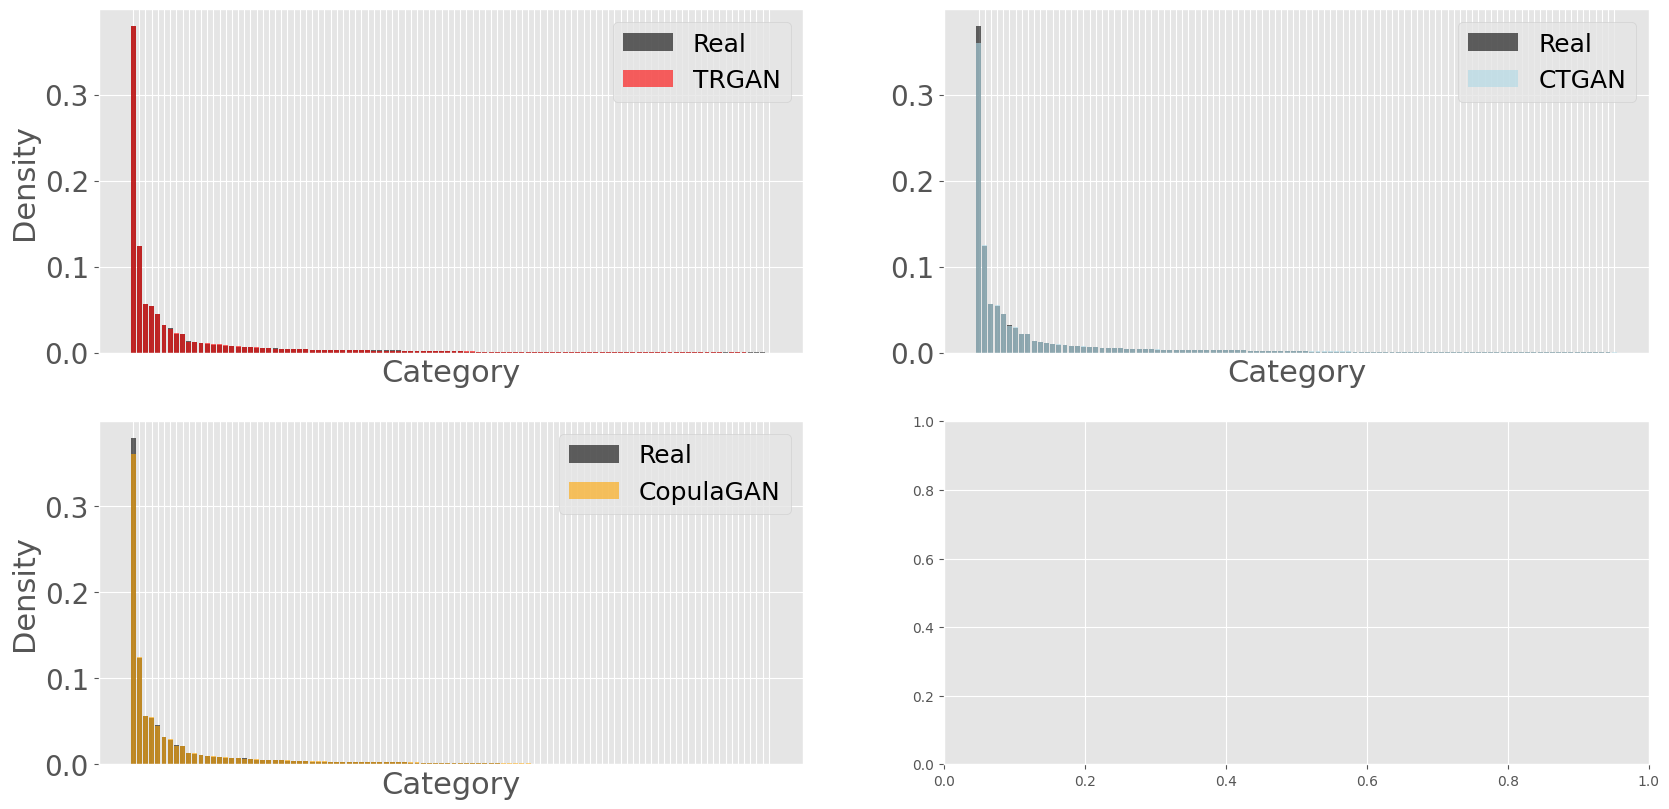

In [39]:
compare_categorical_w_banksformer(data[['mcc', 'amount', 'transaction_date']], synth_df[['mcc', 'amount', 'transaction_date']], synth_df_cat, X_oh, metadata, \
            cat_columns, [],\
            epochs=3, n_samples=len(data), comp_col='mcc', contig_cols=['mcc', 'transaction_date'], load=True)

### Compare numerical columns

In [57]:
def compare_numerical_w_banksformer(data, synth_df, metadata, cat_columns, synth_banks, epochs=10, n_samples=10_000,\
                                    comp_col='amount', load=False, type_comp='log_amount', data_customer=''):
    
    """_summary_

    Returns:
       Object: Return graphs and table with metrics

    Types of visuals:
        - Log amount: log_amount
        - Cash flow: cash_flow

    """
    synth_copulagan, synth_copulagan_cat = copulagan(data, metadata, cat_columns, epochs, n_samples, load)
    synth_ctgan, synth_ctgan_cat = ctgan(data, metadata, cat_columns, epochs, n_samples, load)
    # synth_tvae, synth_tvae_cat = tvae(data, metadata, cat_columns, epochs, n_samples, load)
    synth_banksformer = synth_banks

    if type_comp == 'log_amount':

        data = copy.deepcopy(data)
        synth_df = copy.deepcopy(synth_df)
        data[comp_col] = abs(data[comp_col])
        synth_df[comp_col] = abs(synth_df[comp_col])
        synth_ctgan[comp_col] = abs(synth_ctgan[comp_col])
        synth_copulagan[comp_col] = abs(synth_copulagan[comp_col])
        # synth_banksformer[comp_col] = abs(synth_banksformer[comp_col])

        hist_real = np.histogram(np.log1p(data[comp_col]), normed=True, bins=40)

        fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)

        axs[0, 0].hist(np.log1p(data[comp_col]), bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 0].hist(np.log1p(synth_df[comp_col]), bins=40, label='TRGAN', alpha=0.7, density=True, color='red')
        axs[0, 0].legend(fontsize=18)
        axs[0, 0].set_xlabel('Log amount', fontsize=22)
        axs[0, 0].set_ylabel('Density', fontsize=22)
        axs[0, 0].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[0, 0].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        axs[0, 0].tick_params(labelsize=20)
        # axs[0, 0].set_title('TRGAN')

        axs[0, 1].hist(np.log1p(data[comp_col]), bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 1].hist(np.log1p(synth_ctgan[comp_col]), bins=40, label='CTGAN', alpha=0.7, density=True, color='lightblue')
        axs[0, 1].legend(fontsize=18)
        axs[0, 1].set_xlabel('Log amount', fontsize=22)
        # axs[0, 1].set_ylabel('Density', fontsize=16)
        axs[0, 1].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[0, 1].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        axs[0, 1].tick_params(labelsize=20)
        # axs[0, 1].set_title('CTGAN')

        axs[1, 0].hist(np.log1p(data[comp_col]), bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[1, 0].hist(np.log1p(synth_copulagan[comp_col]), bins=40, label='CopulaGAN', alpha=0.7, density=True, color='orange')
        axs[1, 0].legend(fontsize=18)
        axs[1, 0].set_xlabel('Log amount', fontsize=22)
        axs[1, 0].set_ylabel('Density', fontsize=22)
        axs[1, 0].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[1, 0].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        axs[1, 0].tick_params(labelsize=20)
        # axs[1, 0].set_title('CopulaGAN')

        # axs[1, 1].hist(np.log1p(data[comp_col]), bins=40, label='Real', alpha=0.7, density=True, color='black')
        # axs[1, 1].hist(np.log1p(synth_banksformer[comp_col]), bins=40, label='Banksformer', alpha=0.7, density=True, color='green')
        # axs[1, 1].legend(fontsize=18)
        # axs[1, 1].set_xlabel('Log amount', fontsize=22)
        # # axs[1, 1].set_ylabel('Density', fontsize=16)
        # axs[1, 1].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        # axs[1, 1].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        # axs[1, 1].tick_params(labelsize=20)
        # # axs[1, 1].set_title('Banksformer')

        plt.subplots_adjust(hspace=0.25, wspace=0.12)
        plt.tight_layout(pad=0.5)
        # plt.savefig('synth_amount_rnf.pdf', dpi=300)
        plt.show()

        eval_num = evaluate_numerical([np.log1p(data[comp_col]), np.log1p(synth_df[comp_col]), np.log1p(synth_ctgan[comp_col]),\
                                       np.log1p(synth_copulagan[comp_col])],\
                    ['Real', 'TRGAN', 'CTGAN', 'CopulaGAN'])
        
        return eval_num
    
    elif type_comp == 'cash_flow':

        data = copy.deepcopy(data)
        synth_df = copy.deepcopy(synth_df)
        data['month'] = data['transaction_date'].dt.month
        # synth_banksformer['month'] = synth_banksformer['transaction_date'].dt.month
        synth_df['month'] = synth_df['transaction_date'].dt.month
        synth_ctgan['month'] = synth_ctgan['transaction_date'].dt.month
        synth_copulagan['month'] = synth_copulagan['transaction_date'].dt.month
        # synth_tvae['month'] = synth_tvae['transaction_date'].dt.month

        data = pd.concat([data, data_customer], axis=1)
        synth_ctgan = pd.concat([synth_ctgan, data_customer], axis=1)
        synth_copulagan = pd.concat([synth_copulagan, data_customer], axis=1)

        
        cash_flow_real = (data.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        # cash_flow_banks = (synth_banksformer.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_trgan = (synth_df.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_ctgan = (synth_ctgan.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_copulagan = (synth_copulagan.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()

        q = np.quantile(cash_flow_real, 0.95)

        cash_flow_real = cash_flow_real.iloc[np.where((cash_flow_real <= q) & (cash_flow_real >= -q))[0]]
        # cash_flow_banks = cash_flow_banks.iloc[np.where((cash_flow_banks <= q) & (cash_flow_banks >= -q))[0]]
        cash_flow_trgan = cash_flow_trgan.iloc[np.where((cash_flow_trgan <= q) & (cash_flow_trgan >= -q))[0]]
        cash_flow_ctgan = cash_flow_ctgan.iloc[np.where((cash_flow_ctgan <= q) & (cash_flow_ctgan >= -q))[0]]
        cash_flow_copulagan = cash_flow_copulagan.iloc[np.where((cash_flow_copulagan <= q) & (cash_flow_copulagan >= -q))[0]]
        
        min_length = np.min(list(map(lambda x: len(x), [cash_flow_real, cash_flow_trgan, cash_flow_ctgan, cash_flow_copulagan])))

        cash_flow_real = pd.Series(random.sample(cash_flow_real.values.tolist(), min_length))
        # cash_flow_banks = pd.Series(random.sample(cash_flow_banks.values.tolist(), min_length))
        cash_flow_trgan = pd.Series(random.sample(cash_flow_trgan.values.tolist(), min_length))
        cash_flow_ctgan = pd.Series(random.sample(cash_flow_ctgan.values.tolist(), min_length))
        cash_flow_copulagan = pd.Series(random.sample(cash_flow_copulagan.values.tolist(), min_length))

        hist_real = np.histogram(cash_flow_real, normed=True, bins=40)

        fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)

        axs[0, 0].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 0].hist(cash_flow_trgan, bins=40, label='TRGAN', alpha=0.7, density=True, color='red')
        axs[0, 0].legend(fontsize=18)
        axs[0, 0].set_xlabel('Monthly cash flow', fontsize=22)
        axs[0, 0].set_ylabel('Density', fontsize=22)
        # axs[0, 0].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        # axs[0, 0].set_ylim((0, np.max(hist_real[0]) + 3e-4))
        axs[0, 0].tick_params(labelsize=20)
        # axs[0, 0].set_title('TRGAN')

        axs[0, 1].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 1].hist(cash_flow_ctgan, bins=40, label='CTGAN', alpha=0.7, density=True, color='lightblue')
        axs[0, 1].legend(fontsize=18)
        axs[0, 1].set_xlabel('Monthly cash flow', fontsize=22)
        # axs[0, 1].set_ylabel('Density', fontsize=16)
        # axs[0, 1].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        # axs[0, 1].set_ylim((0, np.max(hist_real[0]) + 3e-4))
        axs[0, 1].tick_params(labelsize=20)
        # axs[0, 1].set_title('CTGAN')

        axs[1, 0].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[1, 0].hist(cash_flow_copulagan, bins=40, label='CopulaGAN', alpha=0.7, density=True, color='orange')
        axs[1, 0].legend(fontsize=18)
        axs[1, 0].set_xlabel('Monthly cash flow', fontsize=22)
        axs[1, 0].set_ylabel('Density', fontsize=22)
        # axs[1, 0].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        # axs[1, 0].set_ylim((0, np.max(hist_real[0]) + 3e-4))
        axs[1, 0].tick_params(labelsize=20)
        # axs[1, 0].set_title('CopulaGAN')

        # axs[1, 1].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        # axs[1, 1].hist(cash_flow_banks, bins=40, label='Banksformer', alpha=0.7, density=True, color='green')
        # axs[1, 1].legend(fontsize=18)
        # axs[1, 1].set_xlabel('Monthly cash flow', fontsize=22)
        # # axs[1, 1].set_ylabel('Density', fontsize=16)
        # axs[1, 1].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        # axs[1, 1].set_ylim((0, np.max(hist_real[0]) + 3e-4))
        # axs[1, 1].tick_params(labelsize=20)
        # # axs[1, 1].set_title('Banksformer')

        plt.subplots_adjust(hspace=0.25, wspace=0.15)
        plt.tight_layout(pad=0.5)
        # plt.savefig('synth_cashflow_rnf.pdf', dpi=300)
        plt.show()

        eval_num = evaluate_numerical_cashflow([cash_flow_real, cash_flow_trgan, cash_flow_ctgan, cash_flow_copulagan],\
                    ['Real', 'TRGAN', 'CTGAN', 'CopulaGAN'])
        
        return eval_num
    
    else:
        print('Choose the type of comparison')

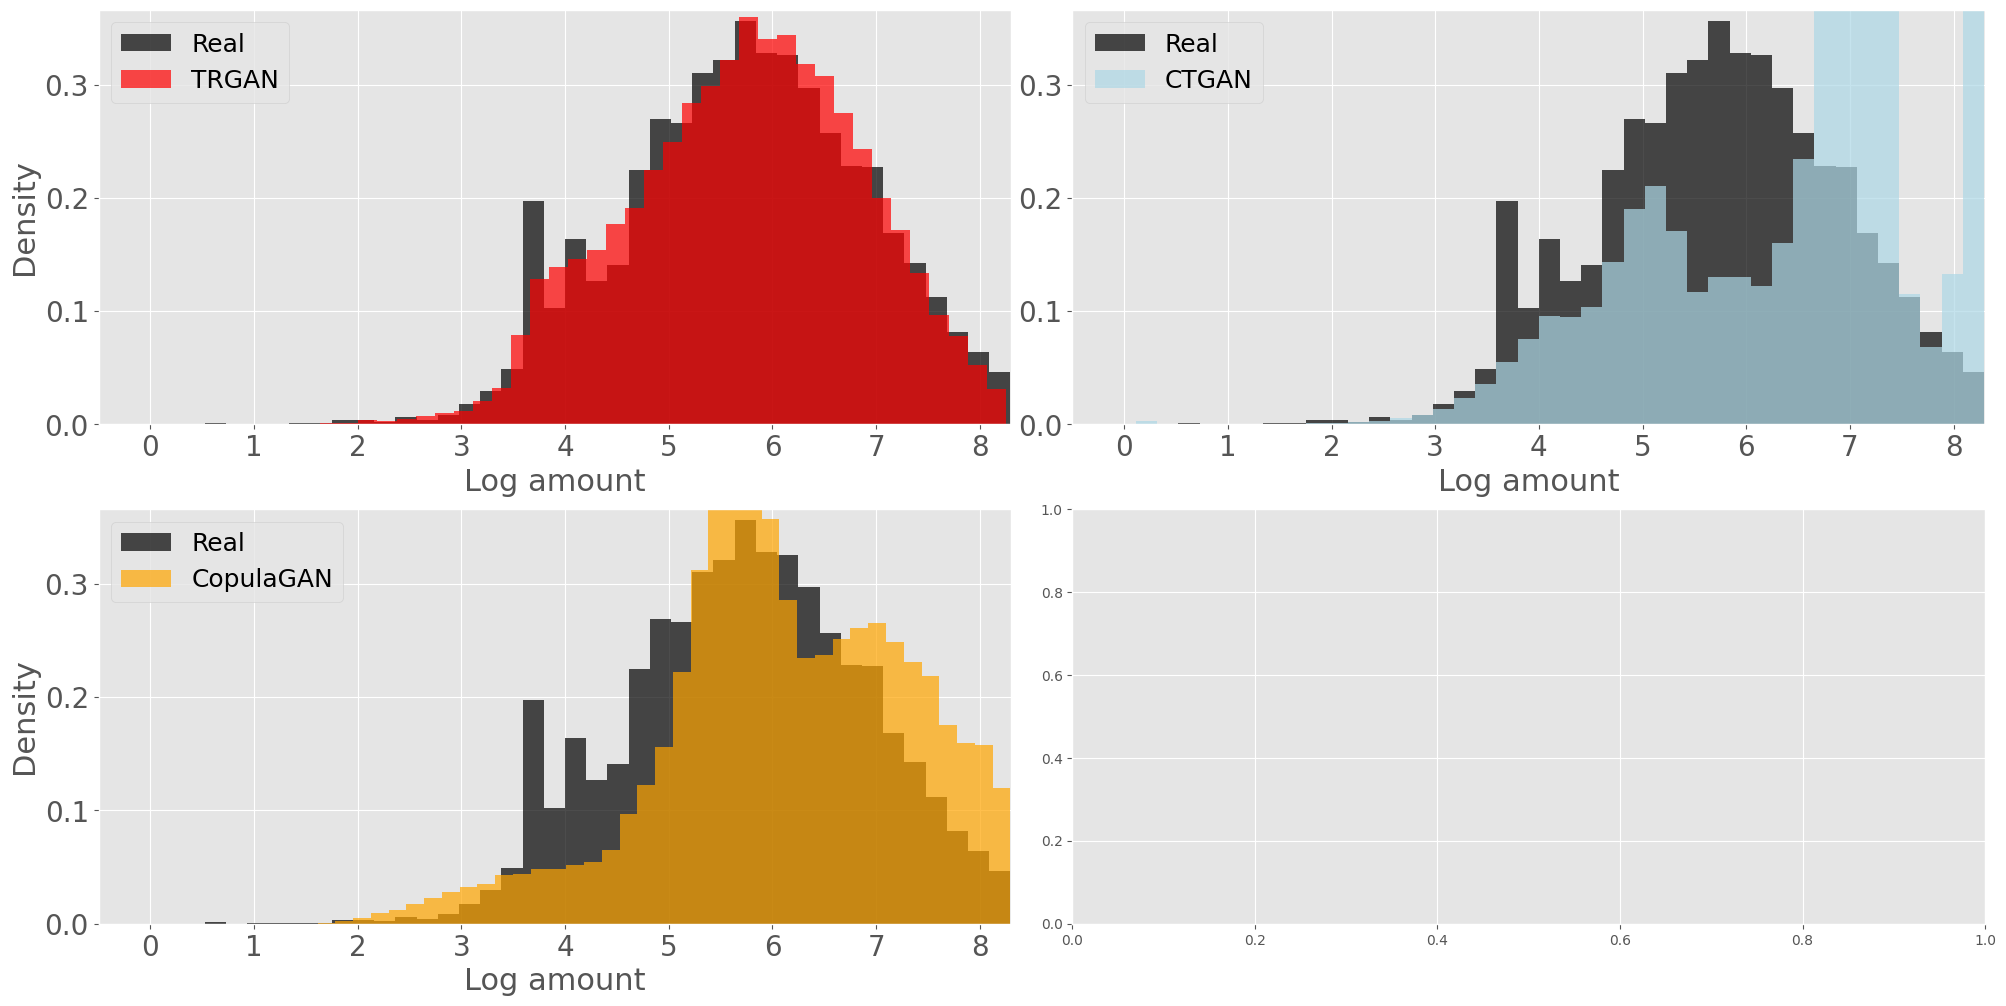

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,5.704023,1.165244,-0.229556,-0.213740,0.000000,0.000000,0.000000
TRGAN,5.729496,1.122570,-0.366848,-0.240710,0.004731,0.025221,0.047962
CTGAN,6.403348,1.266580,0.060636,-0.743785,0.014654,0.347428,0.700378
CopulaGAN,6.081488,1.202002,0.259318,-0.491049,0.012208,0.142670,0.399045


In [58]:
compare_numerical_w_banksformer(data[['mcc', 'amount', 'transaction_date']], synth_df, metadata, cat_columns,\
                                [], epochs=5, n_samples=len(data), comp_col='amount',\
                                load=True, type_comp='log_amount', data_customer=data[['customer']])

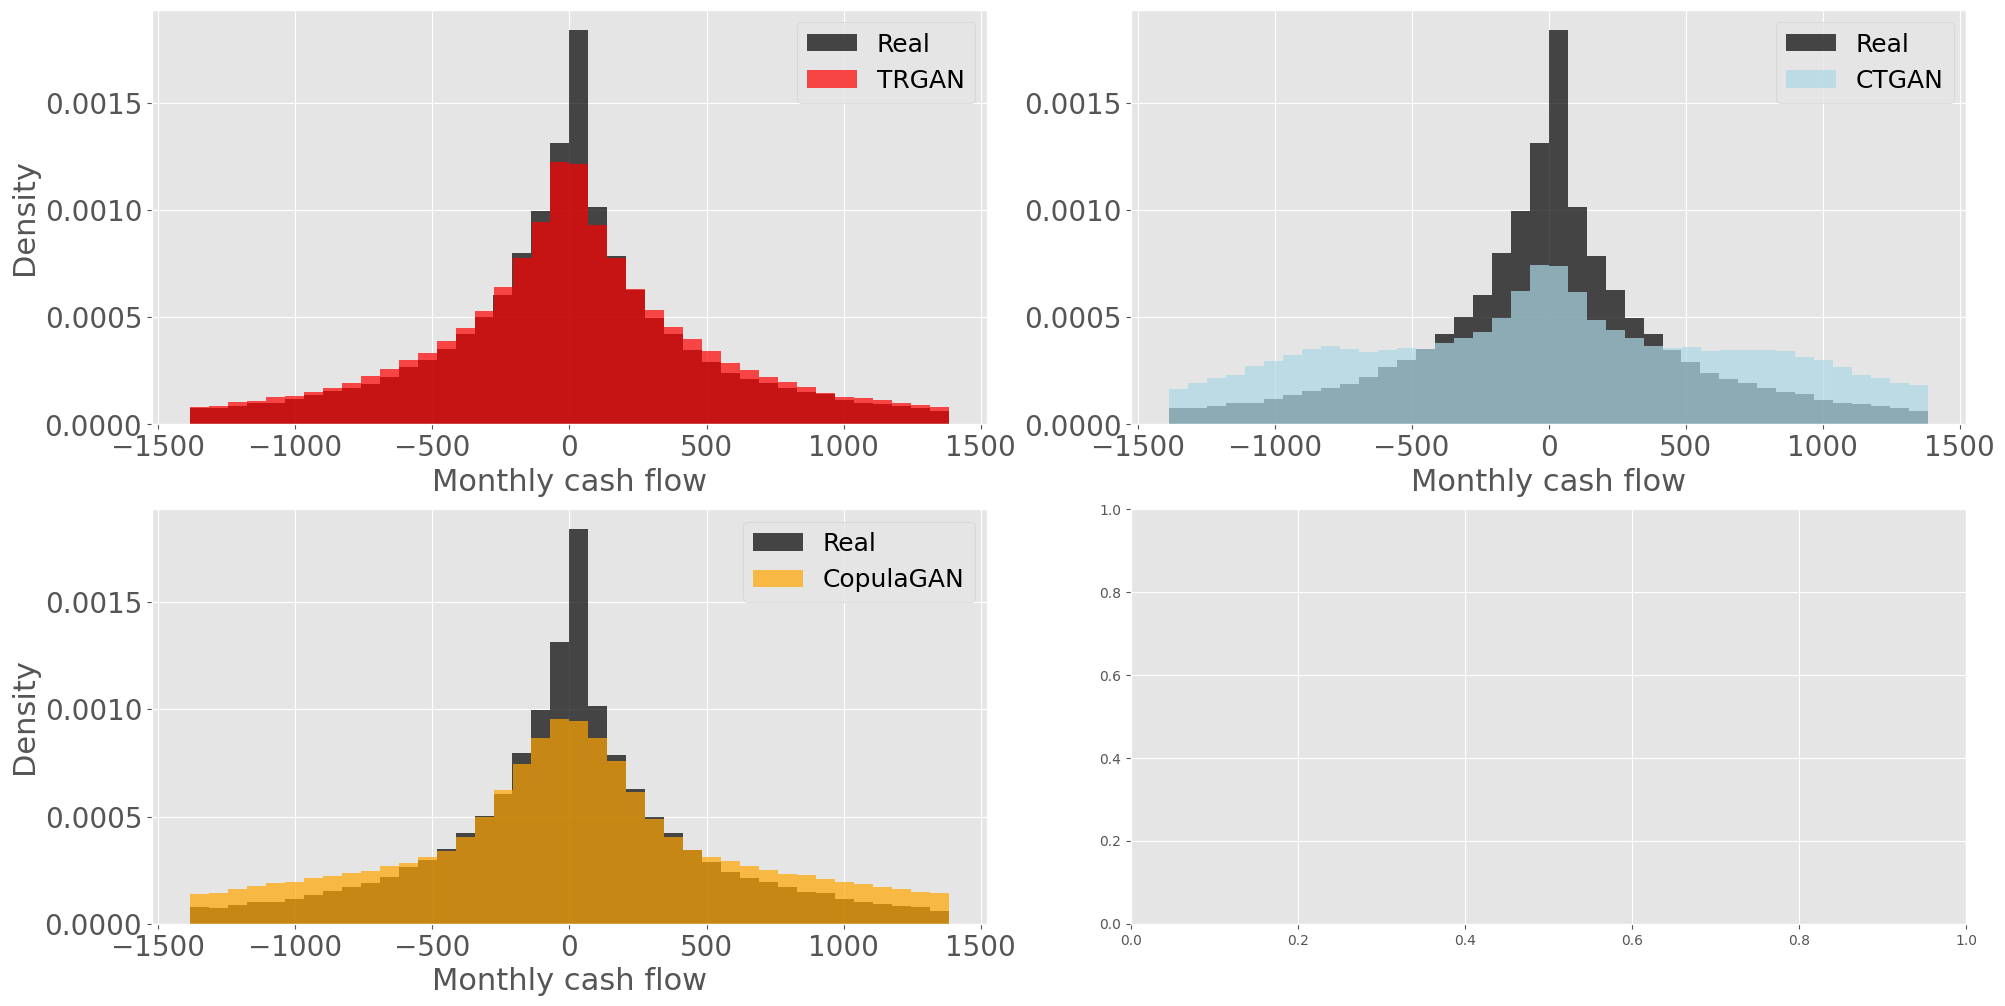

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,-2.885783,484.064713,0.709308,-0.008941,0.000000,0.000000,0.000000
TRGAN,0.157051,518.319108,0.290171,0.003270,0.033254,0.032666,39.974125
CTGAN,-0.302394,685.312019,-0.826749,0.005300,0.099154,0.129691,213.385826
CopulaGAN,0.749846,594.706575,-0.177280,0.000988,0.052175,0.060034,108.926512


In [59]:
compare_numerical_w_banksformer(data[['mcc', 'amount', 'transaction_date']].reset_index(drop=True), synth_df, metadata, cat_columns,\
                                [], epochs=5, n_samples=len(data), comp_col='amount',\
                                load=True, type_comp='cash_flow', data_customer=data[['customer']].reset_index(drop=True))

In [76]:
# compare_categorical_w_banksformer_3grams(data, synth_df, synth_banksformer)

In [ ]:
# synth_df.to_csv(f'Synthetic_data_{experiment_id}.csv', index=False)